# Attack-Defense Tree Environment with Actor-Critic Models

This notebook demonstrates how to use the Attack-Defense Tree Gymnasium environment with actor-critic reinforcement learning models. We'll implement both single-agent and multi-agent scenarios where the attacker and defender learn optimal strategies through self-play.

## 1. Setup and Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque
import random
from ActorCritic import ADTAgent

# Import the ADT environment
from adt_env import AttackDefenseTreeEnv

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

## 2. ADT Environment Setup and Exploration

In [2]:
# Load the environment
env = AttackDefenseTreeEnv("envs/adt_nuovo_env.json", render_mode="human")

print(f"Environment loaded successfully!")
print(f"State space: {env.observation_space}")
print(f"Action space: {env.action_space}")
print(f"Goal: {env.goal}")
print(f"Number of attacker actions: {env.num_attacker_actions}")
print(f"Number of defender actions: {env.num_defender_actions}")

# Get environment dimensions
state_size = env.observation_space.shape[0]
max_action_size = max(env.num_attacker_actions, env.num_defender_actions)

print(f"\nState size: {state_size}")
print(f"Max action size: {max_action_size}")

Number of attacker actions: 6
Number of defender actions: 7
Environment loaded successfully!
State space: Box([0 0 0 0 0 0 0 1 1 1 1 1 1], [1 1 2 2 2 2 2 2 2 2 2 2 2], (13,), int32)
Action space: Discrete(7)
Goal: DataExfiltration
Number of attacker actions: 6
Number of defender actions: 7

State size: 13
Max action size: 7


In [3]:
# Explore the environment structure
obs, info = env.reset()
print("Initial observation shape:", obs.shape)
print("Initial observation:", obs)
print("Initial info:", info)

# Show state variables
print("\nState variables:")
for i, var in enumerate(env.state_vars):
    print(f"  {i}: {var} = {obs[i]}")

Initial observation shape: (13,)
Initial observation: [0 0 0 0 0 0 0 1 1 1 1 1 1]
Initial info: {'current_player': 'attacker', 'goal': 'DataExfiltration', 'terminal': False}

State variables:
  0: DataExfiltration = 0
  1: current_player = 0
  2: AccesstoSensitiveFiles = 0
  3: AccesstoReverseShell = 0
  4: AccesstoExecuteArbitraryCode = 0
  5: AccesstoMySQL = 0
  6: WebReconSuccesful = 0
  7: UnencryptedFiles = 1
  8: SOCKS5ProxyActive = 1
  9: MisconfiguredApache = 1
  10: WebserverPubliclyExposed = 1
  11: CGIscriptsenabled = 1
  12: VulnerableApacheHTTPServerVersion = 1


## 3. Multi-Agent Training Setup

We'll create separate agents for the attacker and defender that learn through self-play.

In [4]:
# Create agents for both players
attacker_agent = ADTAgent(state_size, env.num_attacker_actions, lr=3e-4)
defender_agent = ADTAgent(state_size, env.num_defender_actions, lr=5e-4)  # Higher learning rate for defender

print(f"Attacker agent created with {env.num_attacker_actions} actions (lr=3e-4)")
print(f"Defender agent created with {env.num_defender_actions} actions (lr=5e-4)")

# Training hyperparameters
NUM_EPISODES = 100_000
MAX_STEPS_PER_EPISODE = 50
UPDATE_FREQ = 10  # Update every N episodes
PRINT_FREQ = NUM_EPISODES // 100  # Print progress every 1% of episodes


# Tracking metrics
episode_rewards = {'attacker': [], 'defender': []}
episode_lengths = []
win_rates = {'attacker': [], 'defender': []}
actor_losses = {'attacker': [], 'defender': []}
critic_losses = {'attacker': [], 'defender': []}

print("Training setup complete!")
print(f"Will train for {NUM_EPISODES} episodes")

Attacker agent created with 6 actions (lr=3e-4)
Defender agent created with 7 actions (lr=5e-4)
Training setup complete!
Will train for 100000 episodes


## 4. Training Loop

This is the main training loop where both agents learn through interaction with the environment.

In [ ]:
def train_agents(num_episodes=NUM_EPISODES):
    """Train both agents through self-play with corrected reward system."""
    
    recent_wins = {'attacker': deque(maxlen=100), 'defender': deque(maxlen=100)}
    
    for episode in range(num_episodes):
        obs, info = env.reset()
        
        total_rewards = {'attacker': 0, 'defender': 0}
        episode_length = 0
        
        # Track both agents' last actions for proper penalty assignment
        last_defender_state = None
        last_defender_action = None
        last_defender_log_prob = None
        last_defender_value = None
        
        last_attacker_state = None
        last_attacker_action = None
        last_attacker_log_prob = None
        last_attacker_value = None
        
        for step in range(MAX_STEPS_PER_EPISODE):
            current_player = info['current_player']
            
            # Get available actions for current player
            available_actions = env.get_available_actions()
            
            # Select appropriate agent
            if current_player == 'attacker':
                agent = attacker_agent
            else:
                agent = defender_agent
                
            action, log_prob, value = agent.get_action(obs, available_actions)
            
            # Track both agents' actions for proper penalty assignment
            if current_player == 'defender':
                last_defender_state = obs.copy()
                last_defender_action = action
                last_defender_log_prob = log_prob
                last_defender_value = value
            else:
                last_attacker_state = obs.copy()
                last_attacker_action = action
                last_attacker_log_prob = log_prob
                last_attacker_value = value
            
            # Take action in environment
            next_obs, env_rewards, terminated, truncated, next_info = env.step(action)
            
            # OVERRIDE ENVIRONMENT REWARDS WITH PROPER GAME REWARDS
            # Small step penalty to encourage efficiency
            step_penalty = -1.0
            
            # Initialize proper rewards
            corrected_rewards = {'attacker': step_penalty, 'defender': step_penalty}
            
            # Store experience for current player with corrected step reward
            agent.store_transition(obs, action, step_penalty, log_prob, value, terminated or truncated)
            
            # Update rewards
            total_rewards[current_player] += step_penalty
            
            episode_length += 1
              
            if terminated or truncated:
                # Determine winner based on goal achievement
                goal_achieved = next_obs[0] == 1  # DataExfiltration achieved
                
                if goal_achieved:
                    winner = 'attacker'
                    recent_wins['attacker'].append(1)
                    recent_wins['defender'].append(0)
                    
                    # Strong bonus for attacker winning
                    if last_attacker_action is not None:
                        terminal_bonus = 100.0
                        attacker_agent.store_transition(
                            last_attacker_state, 
                            last_attacker_action, 
                            terminal_bonus, 
                            last_attacker_log_prob, 
                            last_attacker_value, 
                            True
                        )
                        total_rewards['attacker'] += terminal_bonus
                    
                    # Strong penalty for defender losing
                    if last_defender_action is not None:
                        terminal_penalty = -100.0
                        defender_agent.store_transition(
                            last_defender_state, 
                            last_defender_action, 
                            terminal_penalty, 
                            last_defender_log_prob, 
                            last_defender_value, 
                            True
                        )
                        total_rewards['defender'] += terminal_penalty
                        
                else:
                    winner = 'defender'
                    recent_wins['attacker'].append(0)
                    recent_wins['defender'].append(1)

                    # Strong bonus for defender winning
                    if last_defender_action is not None:
                        terminal_bonus = 100.0
                        defender_agent.store_transition(
                            last_defender_state,
                            last_defender_action,
                            terminal_bonus,
                            last_defender_log_prob,
                            last_defender_value,
                            True
                        )
                        total_rewards['defender'] += terminal_bonus
                    
                    # Strong penalty for attacker losing
                    if last_attacker_action is not None:
                        terminal_penalty = -100.0
                        attacker_agent.store_transition(
                            last_attacker_state, 
                            last_attacker_action, 
                            terminal_penalty, 
                            last_attacker_log_prob, 
                            last_attacker_value, 
                            True
                        )
                        total_rewards['attacker'] += terminal_penalty
                        
                break
                
            # Update for next iteration
            obs = next_obs
            info = next_info
        
        # Store episode metrics
        episode_rewards['attacker'].append(total_rewards['attacker'])
        episode_rewards['defender'].append(total_rewards['defender'])
        episode_lengths.append(episode_length)
        
        # Update agents periodically
        if episode % UPDATE_FREQ == 0 and episode > 0:
            # Update attacker
            if len(attacker_agent.states) > 0:
                a_loss, a_c_loss, a_entropy = attacker_agent.update()
                actor_losses['attacker'].append(a_loss)
                critic_losses['attacker'].append(a_c_loss)
            
            # Update defender  
            if len(defender_agent.states) > 0:
                d_loss, d_c_loss, d_entropy = defender_agent.update()
                actor_losses['defender'].append(d_loss)
                critic_losses['defender'].append(d_c_loss)
        
        # Print progress
        if episode == 0 or episode % PRINT_FREQ == 0:
            att_win_rate = np.mean(recent_wins['attacker']) if recent_wins['attacker'] else 0
            def_win_rate = np.mean(recent_wins['defender']) if recent_wins['defender'] else 0
            
            avg_att_reward = np.mean(episode_rewards['attacker'][-PRINT_FREQ:])
            avg_def_reward = np.mean(episode_rewards['defender'][-PRINT_FREQ:])
            avg_length = np.mean(episode_lengths[-PRINT_FREQ:])
            
            print(f"Episode {episode:6d} | "
                  f"Att Win: {att_win_rate:.3f} | Def Win: {def_win_rate:.3f} | "
                  f"Att Reward: {avg_att_reward:6.1f} | Def Reward: {avg_def_reward:6.1f} | "
                  f"Avg Length: {avg_length:.1f}")
            
            # Store win rates for plotting
            win_rates['attacker'].append(att_win_rate)
            win_rates['defender'].append(def_win_rate)
    
    return episode_rewards, episode_lengths, win_rates, actor_losses, critic_losses

# Clear previous training data
episode_rewards = {'attacker': [], 'defender': []}
episode_lengths = []
win_rates = {'attacker': [], 'defender': []}
actor_losses = {'attacker': [], 'defender': []}
critic_losses = {'attacker': [], 'defender': []}

# Create fresh agents with corrected training
attacker_agent = ADTAgent(state_size, env.num_attacker_actions, lr=3e-4)
defender_agent = ADTAgent(state_size, env.num_defender_actions, lr=5e-4)

print("🔄 RETRAINING WITH CORRECTED REWARD SYSTEM")
print("=" * 50)
print("Starting training with proper game-theoretic rewards...")
print("- Step penalty: -1 (efficiency incentive)")
print("- Win bonus: +100 (strong positive signal)")
print("- Loss penalty: -100 (strong negative signal)")
print("- Environment penalties IGNORED")

train_agents(NUM_EPISODES)
print("Training completed with corrected rewards!")

Starting training...
Episode      0 | Att Win: 0.500 | Def Win: 0.500 | Att Reward:   -5.0 | Def Reward: -500.0 | Avg Length: 9.0
Episode   1000 | Att Win: 0.330 | Def Win: 0.670 | Att Reward:  -28.7 | Def Reward: -357.8 | Avg Length: 6.1
Episode   1000 | Att Win: 0.330 | Def Win: 0.670 | Att Reward:  -28.7 | Def Reward: -357.8 | Avg Length: 6.1
Episode   2000 | Att Win: 0.370 | Def Win: 0.630 | Att Reward:  -29.4 | Def Reward: -353.6 | Avg Length: 6.2
Episode   2000 | Att Win: 0.370 | Def Win: 0.630 | Att Reward:  -29.4 | Def Reward: -353.6 | Avg Length: 6.2
Episode   3000 | Att Win: 0.400 | Def Win: 0.600 | Att Reward:  -29.7 | Def Reward: -351.8 | Avg Length: 6.2
Episode   3000 | Att Win: 0.400 | Def Win: 0.600 | Att Reward:  -29.7 | Def Reward: -351.8 | Avg Length: 6.2
Episode   4000 | Att Win: 0.380 | Def Win: 0.620 | Att Reward:  -28.5 | Def Reward: -359.0 | Avg Length: 6.2
Episode   4000 | Att Win: 0.380 | Def Win: 0.620 | Att Reward:  -28.5 | Def Reward: -359.0 | Avg Length: 6.

## 5. Training Results Visualization

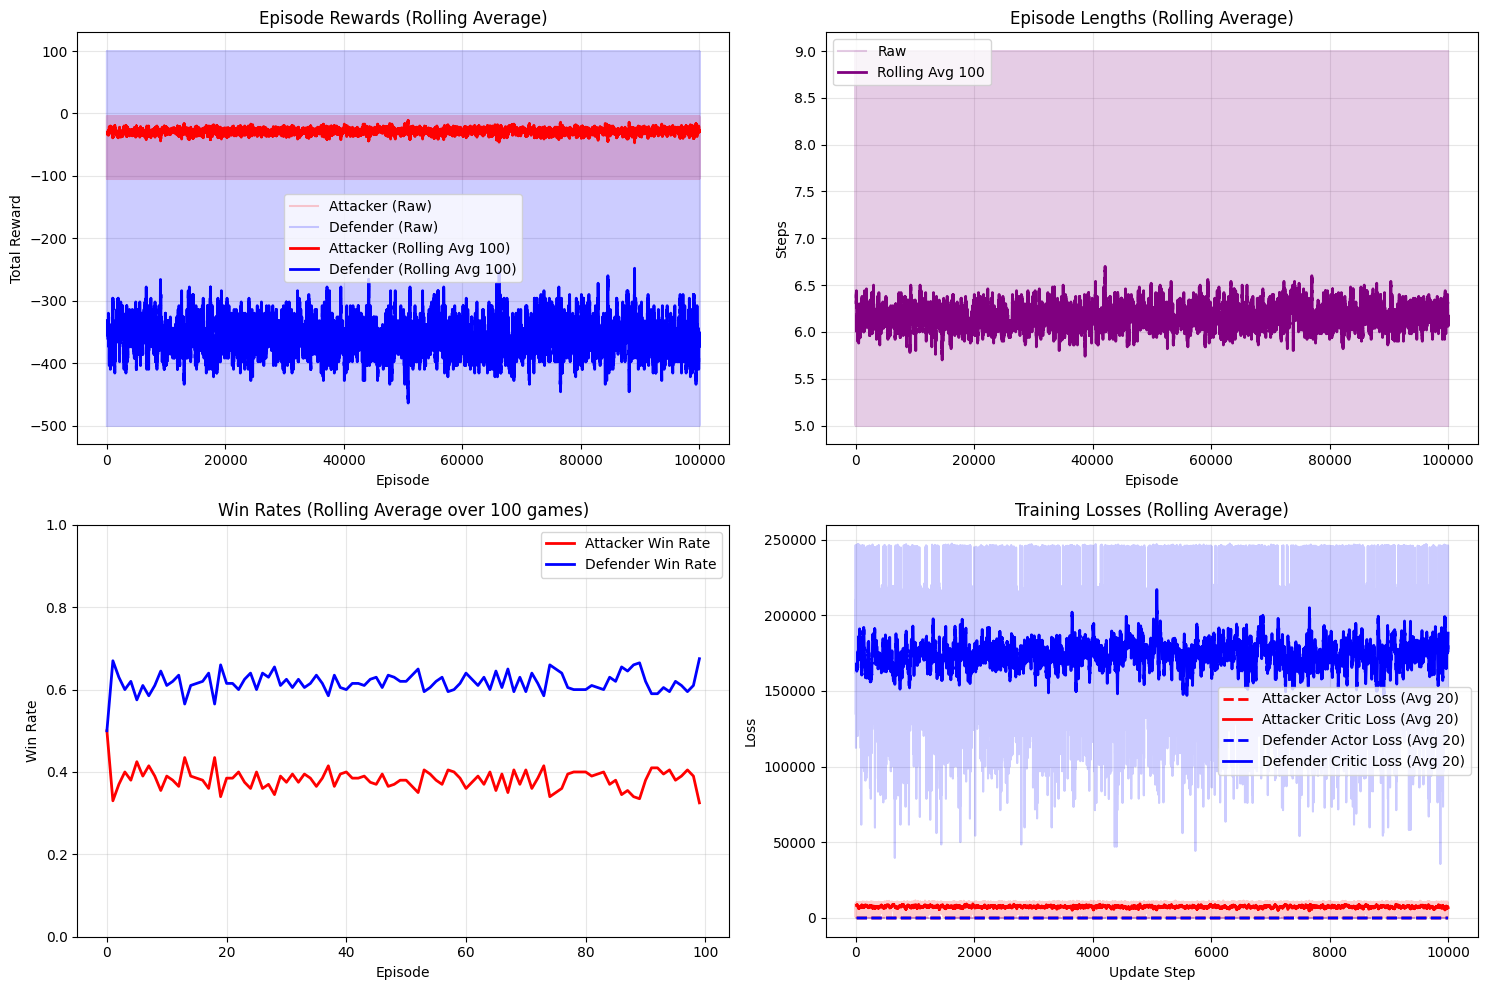


=== Training Summary ===
Total Episodes: 100000
Average Attacker Reward: -28.67
Average Defender Reward: -357.96
Average Episode Length: 6.2
Final Attacker Win Rate: 0.33
Final Defender Win Rate: 0.68

Recent Performance (last 100 episodes):
Recent Attacker Reward: -28.00
Recent Defender Reward: -362.00
Recent Episode Length: 6.1


In [6]:
# Create training metrics visualization with rolling averages
def calculate_rolling_average(data, window=100):
    """Calculate rolling average for smoothing plots."""
    if len(data) < window:
        return data
    return np.convolve(data, np.ones(window)/window, mode='valid')

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Rolling window size
window_size = min(100, len(episode_rewards['attacker']) // 10) if episode_rewards['attacker'] else 1
window_size = max(1, window_size)  # Ensure at least window size 1

# Plot 1: Episode Rewards (with rolling average)
attacker_rewards_smooth = calculate_rolling_average(episode_rewards['attacker'], window_size)
defender_rewards_smooth = calculate_rolling_average(episode_rewards['defender'], window_size)

# Plot raw data with high transparency
axes[0, 0].plot(episode_rewards['attacker'], label='Attacker (Raw)', alpha=0.2, color='red')
axes[0, 0].plot(episode_rewards['defender'], label='Defender (Raw)', alpha=0.2, color='blue')

# Plot rolling averages
if len(attacker_rewards_smooth) > 0:
    x_smooth = range(window_size-1, len(episode_rewards['attacker']))
    axes[0, 0].plot(x_smooth, attacker_rewards_smooth, label=f'Attacker (Rolling Avg {window_size})', 
                   linewidth=2, color='red')
    axes[0, 0].plot(x_smooth, defender_rewards_smooth, label=f'Defender (Rolling Avg {window_size})', 
                   linewidth=2, color='blue')

axes[0, 0].set_title('Episode Rewards (Rolling Average)')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Total Reward')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Episode Lengths (with rolling average)
lengths_smooth = calculate_rolling_average(episode_lengths, window_size)
axes[0, 1].plot(episode_lengths, color='purple', alpha=0.2, label='Raw')
if len(lengths_smooth) > 0:
    x_smooth = range(window_size-1, len(episode_lengths))
    axes[0, 1].plot(x_smooth, lengths_smooth, color='purple', linewidth=2, 
                   label=f'Rolling Avg {window_size}')

axes[0, 1].set_title('Episode Lengths (Rolling Average)')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Steps')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Win Rates (already rolling averages)
if win_rates['attacker']:
    axes[1, 0].plot(win_rates['attacker'], label='Attacker Win Rate', color='red', linewidth=2)
    axes[1, 0].plot(win_rates['defender'], label='Defender Win Rate', color='blue', linewidth=2)
    axes[1, 0].set_title('Win Rates (Rolling Average over 100 games)')
    axes[1, 0].set_xlabel('Episode')
    axes[1, 0].set_ylabel('Win Rate')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_ylim(0, 1)

# Plot 4: Training Losses (with rolling average)
if actor_losses['attacker']:
    loss_window = min(20, len(actor_losses['attacker']) // 5) if actor_losses['attacker'] else 1
    loss_window = max(1, loss_window)
    
    # Attacker losses
    att_actor_smooth = calculate_rolling_average(actor_losses['attacker'], loss_window)
    att_critic_smooth = calculate_rolling_average(critic_losses['attacker'], loss_window)
    
    # Raw data with high transparency
    axes[1, 1].plot(actor_losses['attacker'], alpha=0.2, linestyle='--', color='red')
    axes[1, 1].plot(critic_losses['attacker'], alpha=0.2, linestyle='-', color='red')
    
    # Smoothed data
    if len(att_actor_smooth) > 0:
        x_loss = range(loss_window-1, len(actor_losses['attacker']))
        axes[1, 1].plot(x_loss, att_actor_smooth, label=f'Attacker Actor Loss (Avg {loss_window})', 
                       linestyle='--', color='red', linewidth=2)
        axes[1, 1].plot(x_loss, att_critic_smooth, label=f'Attacker Critic Loss (Avg {loss_window})', 
                       linestyle='-', color='red', linewidth=2)
    
    # Defender losses
    if actor_losses['defender']:
        def_actor_smooth = calculate_rolling_average(actor_losses['defender'], loss_window)
        def_critic_smooth = calculate_rolling_average(critic_losses['defender'], loss_window)
        
        # Raw data
        axes[1, 1].plot(actor_losses['defender'], alpha=0.2, linestyle='--', color='blue')
        axes[1, 1].plot(critic_losses['defender'], alpha=0.2, linestyle='-', color='blue')
        
        # Smoothed data
        if len(def_actor_smooth) > 0:
            x_loss = range(loss_window-1, len(actor_losses['defender']))
            axes[1, 1].plot(x_loss, def_actor_smooth, label=f'Defender Actor Loss (Avg {loss_window})', 
                           linestyle='--', color='blue', linewidth=2)
            axes[1, 1].plot(x_loss, def_critic_smooth, label=f'Defender Critic Loss (Avg {loss_window})', 
                           linestyle='-', color='blue', linewidth=2)
    
    axes[1, 1].set_title('Training Losses (Rolling Average)')
    axes[1, 1].set_xlabel('Update Step')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final statistics
print("\n=== Training Summary ===")
print(f"Total Episodes: {len(episode_rewards['attacker'])}")
print(f"Average Attacker Reward: {np.mean(episode_rewards['attacker']):.2f}")
print(f"Average Defender Reward: {np.mean(episode_rewards['defender']):.2f}")
print(f"Average Episode Length: {np.mean(episode_lengths):.1f}")
if win_rates['attacker']:
    print(f"Final Attacker Win Rate: {win_rates['attacker'][-1]:.2f}")
    print(f"Final Defender Win Rate: {win_rates['defender'][-1]:.2f}")

# Additional statistics for rolling averages
if len(episode_rewards['attacker']) > window_size:
    print(f"\nRecent Performance (last {window_size} episodes):")
    print(f"Recent Attacker Reward: {np.mean(episode_rewards['attacker'][-window_size:]):.2f}")
    print(f"Recent Defender Reward: {np.mean(episode_rewards['defender'][-window_size:]):.2f}")
    print(f"Recent Episode Length: {np.mean(episode_lengths[-window_size:]):.1f}")

## 6. Testing Trained Agents

Let's test our trained agents in a few games to see how they perform.

In [17]:
# Add deterministic action selection for testing
def get_deterministic_action(agent, state, available_actions=None):
    """Get best action instead of sampling during evaluation"""
    try:
        # Ensure state is the right shape and type
        if isinstance(state, np.ndarray):
            state_tensor = torch.FloatTensor(state)
        else:
            state_tensor = torch.FloatTensor(np.array(state))
        
        # Add batch dimension if needed
        if state_tensor.dim() == 1:
            state_tensor = state_tensor.unsqueeze(0)
        
        with torch.no_grad():
            logits, value = agent.network(state_tensor)
            
            # Ensure logits has the right shape
            if logits.dim() > 2:
                logits = logits.squeeze()
            if logits.dim() == 1:
                logits = logits.unsqueeze(0)
            
            # Apply mask for available actions if provided
            if available_actions is not None and len(available_actions) > 0:
                # Create a mask that sets unavailable actions to very low probability
                mask = torch.full_like(logits, -1e9)
                mask[0, available_actions] = 0
                logits = logits + mask
            
            # Take highest probability action instead of sampling
            action = torch.argmax(logits, dim=1).item()
            
        return action
        
    except Exception as e:
        print(f"Error in get_deterministic_action: {e}")
        print(f"State shape: {state.shape if hasattr(state, 'shape') else 'no shape'}")
        print(f"Available actions: {available_actions}")
        # Fallback to random action from available actions
        if available_actions and len(available_actions) > 0:
            return np.random.choice(available_actions)
        else:
            return 0

def test_agents(num_games=100, render=False):
    """Test the trained agents using deterministic policies (best learned actions)."""
    
    results = {'attacker_wins': 0, 'defender_wins': 0, 'games': []}
    
    print(f"Testing {num_games} games with DETERMINISTIC policies (best learned actions)")
    
    try:
        for game in range(num_games):
            if render and game < 5:  # Only show details for first 5 games
                print(f"\n=== Game {game + 1} ===")
            
            obs, info = env.reset()
            
            game_history = []
            total_rewards = {'attacker': 0, 'defender': 0}
            winner = "none"  # Default winner
            
            for step in range(MAX_STEPS_PER_EPISODE):
                current_player = info['current_player']
                available_actions = env.get_available_actions()
                
                # Get best action from trained agent (deterministic)
                if current_player == 'attacker':
                    action = get_deterministic_action(attacker_agent, obs, available_actions)
                    agent_type = "Attacker"
                else:
                    action = get_deterministic_action(defender_agent, obs, available_actions)
                    agent_type = "Defender"
                
                # Get action name for display
                try:
                    if current_player == 'attacker':
                        action_name = env.attacker_actions[str(action)]['name']
                    else:
                        action_name = env.defender_actions[str(action)]['name']
                except (KeyError, IndexError):
                    action_name = f"Action_{action}"
                
                if render and game < 5:
                    print(f"Step {step + 1}: {agent_type} chooses action {action} ({action_name})")
                
                # Take action
                next_obs, rewards, terminated, truncated, next_info = env.step(action)

                total_rewards['attacker'] += rewards['attacker']
                total_rewards['defender'] += rewards['defender']

                game_history.append({
                    'step': step + 1,
                    'player': current_player,
                    'action': action_name,
                    'rewards': rewards,
                    'goal_state': env.state[env.goal]
                })
                
                if terminated or truncated:
                    winner = 'attacker' if env.state[env.goal] == 1 else 'defender'
                    results[f'{winner}_wins'] += 1
                    if render and game < 5:
                        print(f"\nGame {game + 1} ended! Winner: {winner.upper()}")
                        print(f"Final rewards - Attacker: {total_rewards['attacker']}, Defender: {total_rewards['defender']}")
                    break
                obs = next_obs
                info = next_info
            else:
                # Game reached max steps without termination
                if render and game < 5:
                    print(f"\nGame {game + 1} reached max steps without termination")
                    print(f"Final rewards - Attacker: {total_rewards['attacker']}, Defender: {total_rewards['defender']}")
                winner = "draw"
            
            results['games'].append({
                'game_num': game + 1,
                'winner': winner,
                'steps': len(game_history),
                'attacker_reward': total_rewards['attacker'],
                'defender_reward': total_rewards['defender'],
                'history': game_history
            })
            
            # Print progress every 10 games
            if (game + 1) % 10 == 0:
                current_def_wins = results['defender_wins']
                current_att_wins = results['attacker_wins']
                print(f"Progress: {game + 1}/{num_games} games completed. "
                      f"Def: {current_def_wins} ({current_def_wins/(game+1):.1%}), "
                      f"Att: {current_att_wins} ({current_att_wins/(game+1):.1%})")
    
    except Exception as e:
        print(f"Error during testing: {e}")
        print(f"Completed {len(results['games'])} games before error")
    
    return results

# Test the trained agents with deterministic policies
print("="*60)
print("TESTING TRAINED AGENTS")
print("="*60)

test_results = test_agents(num_games=100, render=True)

print(f"\n" + "="*60)
print("TEST RESULTS SUMMARY:")
print(f"Attacker Wins: {test_results['attacker_wins']}")
print(f"Defender Wins: {test_results['defender_wins']}")
if len(test_results['games']) > 0:
    print(f"Defender Win Rate: {test_results['defender_wins']/len(test_results['games']):.1%}")
    print(f"Attacker Win Rate: {test_results['attacker_wins']/len(test_results['games']):.1%}")
print("="*60)

TESTING TRAINED AGENTS
Testing 100 games with DETERMINISTIC policies (best learned actions)

=== Game 1 ===
Step 1: Attacker chooses action 4 (webRecon)
Error in get_deterministic_action: index 6 is out of bounds for dimension 0 with size 6
State shape: (13,)
Available actions: [0, 1, 2, 3, 4, 5, 6]
Step 2: Attacker chooses action 0 (exfiltrateData)
Step 3: Defender chooses action 5 (disableCGIScripts)
Error in get_deterministic_action: index 6 is out of bounds for dimension 0 with size 6
State shape: (13,)
Available actions: [1, 2, 3, 4, 5, 6]
Step 4: Attacker chooses action 3 (getFiles)
Step 5: Defender chooses action 3 (deactivateSOCKS5Proxy)
Error in get_deterministic_action: index 6 is out of bounds for dimension 0 with size 6
State shape: (13,)
Available actions: [1, 2, 4, 5, 6]
Step 6: Attacker chooses action 2 (bufferOverflow)
Step 7: Defender chooses action 2 (encryptFile)

Game 1 ended! Winner: DEFENDER
Final rewards - Attacker: -55, Defender: -470

=== Game 2 ===
Step 1: Att


=== DETAILED TEST ANALYSIS ===
Total Games: 100
Attacker Wins: 83 (83.0%)
Defender Wins: 17 (17.0%)
Draws: 0 (0.0%)
Average steps when attacker wins: 5.8
Average steps when defender wins: 6.8
Average attacker reward: -93.5
Average defender reward: -648.2

First 10 Games Summary:


,Game,Winner,Steps,Attacker Reward,Defender Reward
0,1,defender,7,-55,-470
1,2,defender,7,-55,-470
2,3,defender,7,-55,-380
3,4,attacker,7,-115,-655
4,5,attacker,5,-95,-605
5,6,attacker,7,-115,-870
6,7,attacker,7,-115,-810
7,8,attacker,9,-145,-990
8,9,attacker,5,-95,-595
9,10,attacker,7,-115,-810


Error creating visualizations: x and y must have same first dimension, but have shapes (18,) and (19,)
Skipping plots due to data issues.

DEFENDER FAILURE ANALYSIS
When attacker wins:
Short games (≤5 steps): 55 (66.3%)
Medium games (6-15 steps): 28 (33.7%)
Long games (>15 steps): 0 (0.0%)

First 3 attacker wins analysis:
Game 4: 7 steps, Att reward: -115, Def reward: -655
Game 5: 5 steps, Att reward: -95, Def reward: -605
Game 6: 7 steps, Att reward: -115, Def reward: -870

Defender success patterns:
Short games (≤5 steps): 2 (11.8%)
Medium games (6-15 steps): 15 (88.2%)
Long games (>15 steps): 0 (0.0%)


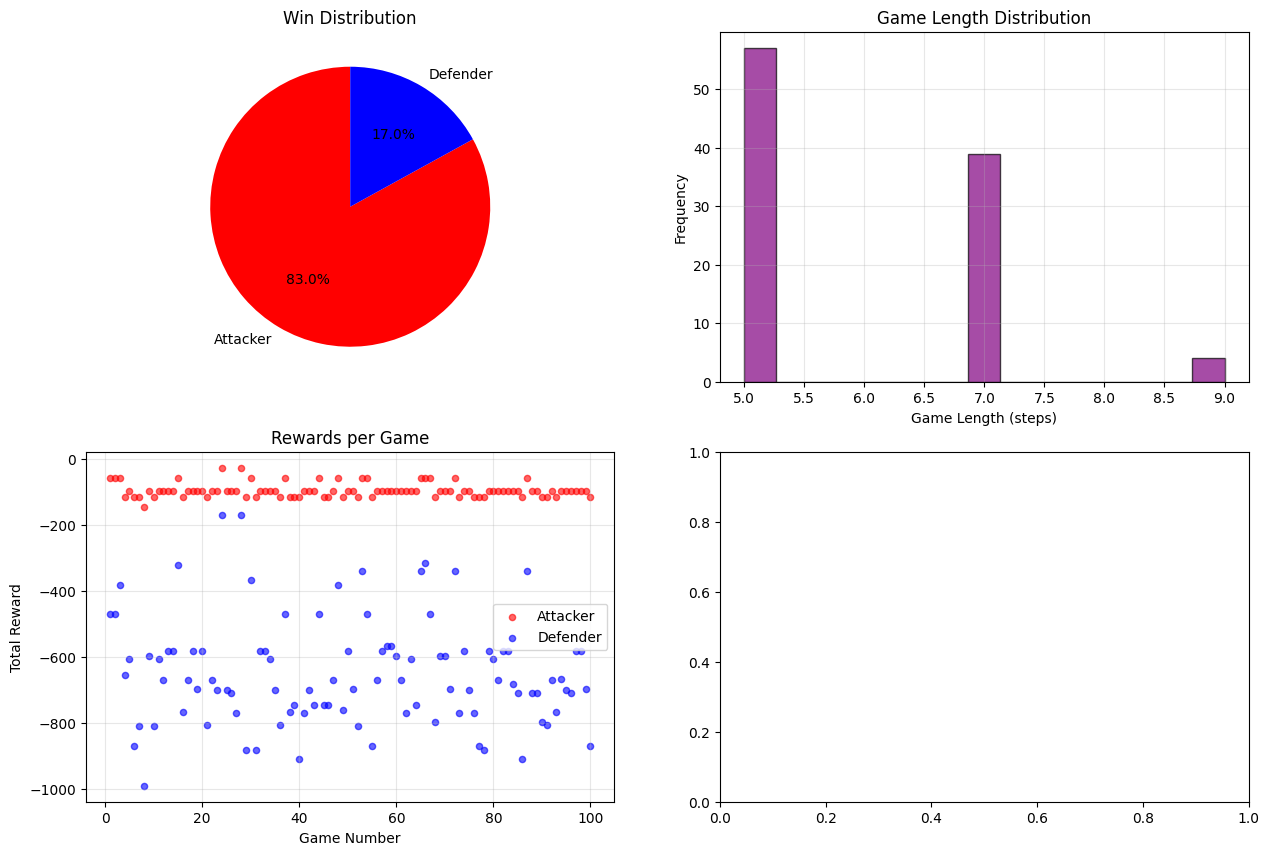

In [18]:
# Analyze test results with error handling
print("\n=== DETAILED TEST ANALYSIS ===")

# Check if test_results exists and has the expected structure
if 'test_results' not in locals() or not test_results or 'games' not in test_results:
    print("ERROR: No test results found. Please run the testing cell first.")
    print("Creating empty results structure for safety...")
    test_results = {'attacker_wins': 0, 'defender_wins': 0, 'games': []}

# Check if we have any games to analyze
if not test_results['games']:
    print("No games were completed during testing. Cannot perform analysis.")
else:
    # Basic statistics
    attacker_wins = [game for game in test_results['games'] if game['winner'] == 'attacker']
    defender_wins = [game for game in test_results['games'] if game['winner'] == 'defender']
    draws = [game for game in test_results['games'] if game['winner'] == 'draw']

    print(f"Total Games: {len(test_results['games'])}")
    print(f"Attacker Wins: {len(attacker_wins)} ({len(attacker_wins)/len(test_results['games']):.1%})")
    print(f"Defender Wins: {len(defender_wins)} ({len(defender_wins)/len(test_results['games']):.1%})")
    print(f"Draws: {len(draws)} ({len(draws)/len(test_results['games']):.1%})")

    # Game length analysis
    if attacker_wins:
        avg_steps_att_wins = np.mean([game['steps'] for game in attacker_wins])
        print(f"Average steps when attacker wins: {avg_steps_att_wins:.1f}")

    if defender_wins:
        avg_steps_def_wins = np.mean([game['steps'] for game in defender_wins])
        print(f"Average steps when defender wins: {avg_steps_def_wins:.1f}")

    # Reward analysis
    try:
        att_rewards = [game['attacker_reward'] for game in test_results['games']]
        def_rewards = [game['defender_reward'] for game in test_results['games']]

        print(f"Average attacker reward: {np.mean(att_rewards):.1f}")
        print(f"Average defender reward: {np.mean(def_rewards):.1f}")
    except KeyError as e:
        print(f"Error accessing reward data: {e}")
        att_rewards = [0] * len(test_results['games'])
        def_rewards = [0] * len(test_results['games'])

    # Create a summary DataFrame with error handling
    try:
        game_summary = pd.DataFrame([
            {
                'Game': game.get('game_num', i+1),
                'Winner': game.get('winner', 'unknown'),
                'Steps': game.get('steps', 0),
                'Attacker Reward': game.get('attacker_reward', 0),
                'Defender Reward': game.get('defender_reward', 0)
            }
            for i, game in enumerate(test_results['games'])
        ])

        if len(game_summary) > 0:
            print("\nFirst 10 Games Summary:")
            display(game_summary.head(10))
        else:
            print("No game data available for summary.")
    except Exception as e:
        print(f"Error creating game summary: {e}")

    # Visualization with error handling
    try:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Win distribution pie chart
        wins = [test_results.get('attacker_wins', 0), test_results.get('defender_wins', 0)]
        if len(draws) > 0:
            wins.append(len(draws))
            labels = ['Attacker', 'Defender', 'Draw']
            colors = ['red', 'blue', 'gray']
        else:
            labels = ['Attacker', 'Defender']
            colors = ['red', 'blue']

        # Only plot if we have data
        if sum(wins) > 0:
            axes[0, 0].pie(wins, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
            axes[0, 0].set_title('Win Distribution')
        else:
            axes[0, 0].text(0.5, 0.5, 'No game data', ha='center', va='center', transform=axes[0, 0].transAxes)
            axes[0, 0].set_title('Win Distribution - No Data')

        # Game length distribution
        if test_results['games']:
            game_lengths = [game.get('steps', 0) for game in test_results['games']]
            axes[0, 1].hist(game_lengths, bins=15, alpha=0.7, color='purple', edgecolor='black')
            axes[0, 1].set_xlabel('Game Length (steps)')
            axes[0, 1].set_ylabel('Frequency')
            axes[0, 1].set_title('Game Length Distribution')
            axes[0, 1].grid(True, alpha=0.3)
        else:
            axes[0, 1].text(0.5, 0.5, 'No game data', ha='center', va='center', transform=axes[0, 1].transAxes)
            axes[0, 1].set_title('Game Length Distribution - No Data')

        # Rewards comparison
        if test_results['games']:
            game_nums = list(range(1, len(test_results['games']) + 1))
            axes[1, 0].scatter(game_nums, att_rewards, alpha=0.6, color='red', label='Attacker', s=20)
            axes[1, 0].scatter(game_nums, def_rewards, alpha=0.6, color='blue', label='Defender', s=20)
            axes[1, 0].set_xlabel('Game Number')
            axes[1, 0].set_ylabel('Total Reward')
            axes[1, 0].set_title('Rewards per Game')
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3)
        else:
            axes[1, 0].text(0.5, 0.5, 'No game data', ha='center', va='center', transform=axes[1, 0].transAxes)
            axes[1, 0].set_title('Rewards per Game - No Data')

        # Win rate over time (rolling window)
        if len(test_results['games']) >= 10:
            window = 10
            win_rates_over_time = []
            for i in range(0, len(test_results['games']) - window + 1, 5):  # Every 5 games
                window_games = test_results['games'][i:i+window]
                def_wins_in_window = sum(1 for game in window_games if game.get('winner') == 'defender')
                win_rates_over_time.append(def_wins_in_window / window)

            game_windows = range(window//2, len(test_results['games']) - window//2, 5)
            axes[1, 1].plot(game_windows, win_rates_over_time, 'o-', color='blue', linewidth=2, markersize=4)
            axes[1, 1].set_xlabel('Game Number (center of window)')
            axes[1, 1].set_ylabel('Defender Win Rate')
            axes[1, 1].set_title(f'Defender Win Rate Over Time (rolling {window}-game window)')
            axes[1, 1].grid(True, alpha=0.3)
            axes[1, 1].set_ylim(0, 1)
        else:
            axes[1, 1].text(0.5, 0.5, f'Need ≥10 games\n(have {len(test_results["games"])})', 
                           ha='center', va='center', transform=axes[1, 1].transAxes)
            axes[1, 1].set_title('Win Rate Over Time - Insufficient Data')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error creating visualizations: {e}")
        print("Skipping plots due to data issues.")

    # Failure pattern analysis with error handling
    print("\n" + "="*60)
    print("DEFENDER FAILURE ANALYSIS")
    print("="*60)

    try:
        if attacker_wins:
            # Analyze game lengths when attacker wins
            short_games = [game for game in attacker_wins if game.get('steps', 0) <= 5]
            medium_games = [game for game in attacker_wins if 5 < game.get('steps', 0) <= 15]
            long_games = [game for game in attacker_wins if game.get('steps', 0) > 15]
            
            print(f"When attacker wins:")
            print(f"Short games (≤5 steps): {len(short_games)} ({len(short_games)/len(attacker_wins):.1%})")
            print(f"Medium games (6-15 steps): {len(medium_games)} ({len(medium_games)/len(attacker_wins):.1%})")
            print(f"Long games (>15 steps): {len(long_games)} ({len(long_games)/len(attacker_wins):.1%})")
            
            print(f"\nFirst 3 attacker wins analysis:")
            for i, game in enumerate(attacker_wins[:3]):
                steps = game.get('steps', 0)
                att_reward = game.get('attacker_reward', 0)
                def_reward = game.get('defender_reward', 0)
                game_num = game.get('game_num', i+1)
                print(f"Game {game_num}: {steps} steps, "
                      f"Att reward: {att_reward}, Def reward: {def_reward}")
        else:
            print("No attacker wins to analyze - defender won all games!")

        if defender_wins:
            print(f"\nDefender success patterns:")
            def_short = [game for game in defender_wins if game.get('steps', 0) <= 5]
            def_medium = [game for game in defender_wins if 5 < game.get('steps', 0) <= 15]
            def_long = [game for game in defender_wins if game.get('steps', 0) > 15]
            
            print(f"Short games (≤5 steps): {len(def_short)} ({len(def_short)/len(defender_wins):.1%})")
            print(f"Medium games (6-15 steps): {len(def_medium)} ({len(def_medium)/len(defender_wins):.1%})")
            print(f"Long games (>15 steps): {len(def_long)} ({len(def_long)/len(defender_wins):.1%})")
    except Exception as e:
        print(f"Error in failure analysis: {e}")
        print("Unable to complete failure pattern analysis.")

## 7. Policy Analysis

Let's analyze what policies our agents have learned.

In [ ]:
def analyze_policy(agent, env, player_name, state_samples=5):
    """Analyze the learned policy of an agent."""
    
    print(f"\n=== {player_name.upper()} POLICY ANALYSIS ===")
    
    # Sample some states
    policy_analysis = []
    
    for sample in range(state_samples):
        obs, info = env.reset()
        
        # Make sure we're analyzing the right player
        steps = 0
        while info['current_player'] != player_name.lower() and steps < 10:
            # Take a random action to advance the game
            action = env.action_space.sample()
            obs, _, terminated, truncated, info = env.step(action)
            if terminated or truncated:
                obs, info = env.reset()
            steps += 1
        
        if info['current_player'] == player_name.lower():
            # Get policy probabilities
            state_tensor = torch.FloatTensor(obs)
            with torch.no_grad():
                policy, value = agent.network(state_tensor)
                policy = policy.squeeze().numpy()
            
            # Get available actions
            available_actions = env.get_available_actions()
            
            # Get action names
            if player_name.lower() == 'attacker':
                actions_dict = env.attacker_actions
            else:
                actions_dict = env.defender_actions
            
            # Analyze top actions
            top_actions = np.argsort(policy)[-5:][::-1]  # Top 5 actions
            
            print(f"\nSample {sample + 1} - State Value: {value.item():.3f}")
            print("Top 5 preferred actions:")
            
            for i, action_id in enumerate(top_actions):
                if action_id < len(actions_dict):
                    action_name = actions_dict[str(action_id)]['name']
                    prob = policy[action_id]
                    available = "✓" if action_id in available_actions else "✗"
                    print(f"  {i+1}. Action {action_id} ({action_name}): {prob:.3f} [{available}]")
            
            policy_analysis.append({
                'sample': sample + 1,
                'state_value': value.item(),
                'policy': policy,
                'available_actions': available_actions,
                'state': obs
            })
    
    return policy_analysis

# Analyze both agents
attacker_analysis = analyze_policy(attacker_agent, env, "Attacker")
defender_analysis = analyze_policy(defender_agent, env, "Defender")

## 8. Save Trained Models

In [ ]:
# Save the trained models
import os

models_dir = "/home/valerio/PANACEA/trained_models"
os.makedirs(models_dir, exist_ok=True)

# Save attacker model
torch.save({
    'model_state_dict': attacker_agent.network.state_dict(),
    'optimizer_state_dict': attacker_agent.optimizer.state_dict(),
    'state_size': state_size,
    'action_size': env.num_attacker_actions
}, os.path.join(models_dir, 'attacker_actor_critic.pth'))

# Save defender model
torch.save({
    'model_state_dict': defender_agent.network.state_dict(),
    'optimizer_state_dict': defender_agent.optimizer.state_dict(),
    'state_size': state_size,
    'action_size': env.num_defender_actions
}, os.path.join(models_dir, 'defender_actor_critic.pth'))

# Save training metrics
training_data = {
    'episode_rewards': episode_rewards,
    'episode_lengths': episode_lengths,
    'win_rates': win_rates,
    'actor_losses': actor_losses,
    'critic_losses': critic_losses,
    'test_results': test_results
}

import pickle
with open(os.path.join(models_dir, 'training_metrics.pkl'), 'wb') as f:
    pickle.dump(training_data, f)

print(f"Models and training data saved to {models_dir}")
print("Files saved:")
for file in os.listdir(models_dir):
    print(f"  - {file}")